# 07 - bentoml

https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/07-bento-production/homework.md

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [21]:
import bentoml
from pydantic import BaseModel

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb

# Question 1

* Install BentoML
* What's the version of BentoML you installed?
* Use --version to find out

In [4]:
!bentoml --version

bentoml, version 1.0.7


Answer: 1.0.7

# Question 2

Run the notebook which contains the xgboost model from module 6 i.e previous module and save the xgboost model with BentoML.

In [5]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'
df = pd.read_csv(data)

In [6]:
df.columns = df.columns.str.lower()

status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

df = df[df.status != 'unk'].reset_index(drop=True)

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=11)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

del df_train['status']
del df_test['status']

In [8]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.fillna(0).to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

test_dicts = df_test.fillna(0).to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [9]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [10]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [13]:
bentoml.xgboost.save_model(
            'credit_risk_model',
            model,
            custom_objects={
                'dictVectorizer': dv
            })

How big approximately is the saved BentoML model? Size can slightly vary depending on your local development environment. Choose the size closest to your model.

In [19]:
!du -h /home/user/bentoml/models/credit_risk_model/mdmhu3srkkg7pj43/

212K	/home/user/bentoml/models/credit_risk_model/mdmhu3srkkg7pj43/


Answer: 114kb (closest variant)

# Question 3

In [22]:
class UserProfile(BaseModel):
    name: str
    age: int
    country: str
    rating: float

# Question 4

We've prepared a model for you that you can import using:

In [34]:
!bentoml models list

 Tag                           Module           Size        Creation Time       
 credit_risk_model:vihx62spu…  bentoml.xgboost  195.60 KiB  2022-10-19 17:00:45 
 mlzoomcamp_homework:qtzdz3s…  bentoml.sklearn  5.79 KiB    2022-10-14 01:42:14 


In [35]:
!bentoml models get mlzoomcamp_homework:qtzdz3slg6mwwdu5

name: mlzoomcamp_homework                                                       
version: qtzdz3slg6mwwdu5                                                       
module: bentoml.sklearn                                                         
labels: {}                                                                      
options: {}                                                                     
metadata: {}                                                                    
context:                                                                        
  framework_name: sklearn                                                       
  framework_versions:                                                           
    scikit-learn: 1.1.1                                                         
  bentoml_version: 1.0.7                                                        
  python_version: 3.9.12                                                        
signatures:                 

What version of scikit-learn was this model trained with?

Answer: 1.1.1

# Question 5

Create a bento out of this scikit-learn model. The output type for this endpoint should be NumpyNdarray()

Send this array to the Bento:

[[6.4,3.5,4.5,1.2]]

You can use curl or the Swagger UI. What value does it return?

In [40]:
!curl -X POST --data '[[6.4,3.5,4.5,1.2]]' http://0.0.0.0:3000/classify

[1]

Answer: 1

# Question 6

Ensure to serve your bento with --production for this question

Ensure that it is pointed at your bento's endpoint (In case you didn't name your endpoint "classify")

Configure 100 users with ramp time of 10 users per second. 

Update your bento's runner tag and test with both models. Which model allows more traffic (more throughput) as you ramp up the traffic?

Which model has better performance at higher volumes?

* The first model
* The second model

__The first model__:

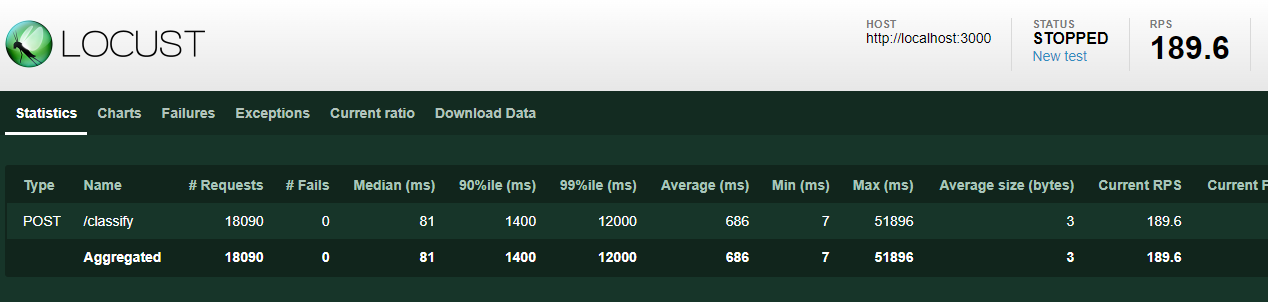    

__The second model:__

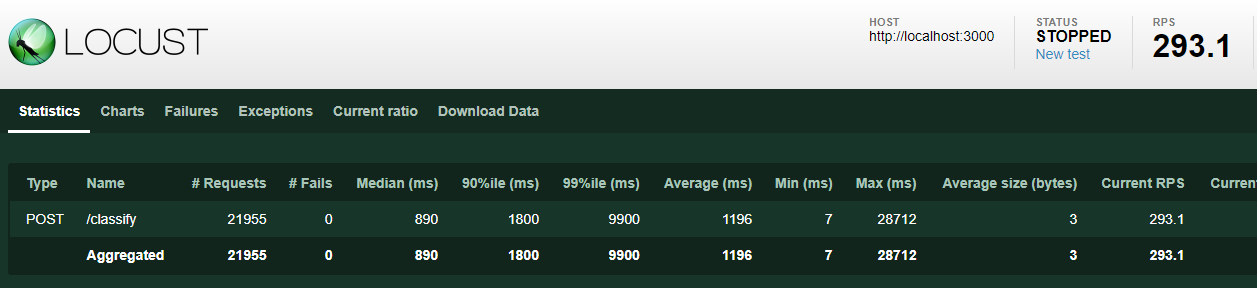

Answer: the second model allows more traffic